# Regression using SKLearn (Light Gradient Boosting Machine)

## Loading Libraries

In [56]:
# load sample dataset
import pandas as pd
import seaborn as sns

from ydata_profiling import ProfileReport
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import residuals_plot

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import lightgbm as lgb





In [57]:
df = pd.read_csv('./Data/UpdateCubicZirconia.csv')
print(df.shape)
df.head()

(26270, 10)


,carat,cut,color,clarity,depth,table,Length_mm,Width_mm,Height_mm,price
0,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


### This Dataset is clean as I cleaned for the date previously in PyCaret Pipline


In [58]:
# set aside and save unseen data set
data_unseen = df.sample(n=200, random_state=42)
data        = df.drop(data_unseen.index)
print(f'Data for model: {data.shape},\nData for unseen predictions: {data_unseen.shape}')
data_unseen.to_csv('./Data/Cubic_unseen.csv', index=False)

Data for model: (26070, 10),
Data for unseen predictions: (200, 10)


In [59]:
# data.columns!='charges'
X = data.loc[: , data.columns!='price']
y = data.loc[: , data.columns=='price']

In [60]:
X.head()

,carat,cut,color,clarity,depth,table,Length_mm,Width_mm,Height_mm
0,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66
1,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70
2,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78
3,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96
4,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65


In [61]:
y.head()

,price
0,499
1,984
2,6289
3,1082
4,779


In [62]:
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
# encoding 
# get the categorical and numeric column names
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(num_cols, '\n', cat_cols)

['carat', 'depth', 'table', 'Length_mm', 'Width_mm', 'Height_mm'] 
 ['cut', 'color', 'clarity']


In [64]:
# pipeline for numerical columns
num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [65]:
# pipeline for categorical columns
cat_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='N/A'),
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)
cat_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='N/A', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [66]:
# combine both the pipelines
full_pipe = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])
full_pipe

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['carat', 'depth', 'table', 'Length_mm',
                                  'Width_mm', 'Height_mm']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='N/A',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['cut', 'color', 'clarity'])])

In [67]:
full_pipe

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['carat', 'depth', 'table', 'Length_mm',
                                  'Width_mm', 'Height_mm']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='N/A',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['cut', 'color', 'clarity'])])

In [68]:
# build the model
lgbm_cubic = make_pipeline(full_pipe, lgb.LGBMRegressor(random_state=42))
lgbm_cubic

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'Length_mm', 'Width_mm',
                                                   'Height_mm']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='N/A',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('lgbmregressor', LGBMRegressor(random_state=42))])

In [69]:
# train the model
lgbm_cubic.fit(X_train, y_train)


C:\Users\kadee\miniconda3\envs\pc3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\kadee\miniconda3\envs\pc3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'Length_mm', 'Width_mm',
                                                   'Height_mm']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='N/A',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['cut', 'color',
                                                   'clarity'])])),
                ('lgbmregressor', LGBMRegressor(random_state=42))])

In [72]:
# make predictions on the test set
y_pred = lgbm_cubic.predict(X_test)

In [73]:
# measure accuracy
print('R2:', r2_score(y_test, y_pred))

R2: 0.9800504747677332


In [74]:
# done manually to break out the example above
y_test['y_pred'] = y_pred
test_scores = y_test.copy()
test_scores

,price,y_pred
1452,7761,7742.076204
2482,2453,2494.184573
3047,957,826.346628
22784,9461,10179.212423
25177,974,902.122495
...,...,...
11773,2743,2522.248555
4039,1154,1250.833950
14909,1637,1680.795655
8118,664,623.246450


In [75]:
r2 = r2_score(test_scores['price'], test_scores['y_pred'])
mae = mean_absolute_error(test_scores['price'], test_scores['y_pred'])
mean_act = test_scores['price'].mean()
mean_pred = test_scores['y_pred'].mean()
mape = mean_absolute_percentage_error(test_scores['price'], test_scores['y_pred'])
print(f'R2: {r2}\nmae: {mae}\nact_mean: {mean_act}\npred_mean: {mean_pred}\nmape: {mape}')

R2: 0.9800504747677332
mae: 290.24549799715834
act_mean: 3883.675297276563
pred_mean: 3886.0228280797314
mape: 0.08544642607003256


In [76]:
import joblib
joblib.dump(lgbm_cubic, 'CubicModel.pkl')
print(lgbm_cubic)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['carat', 'depth', 'table',
                                                   'Length_mm', 'Width_mm',
                                                   'Height_mm']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='N/A',
                                                                                 strat

## Plotting 

### Residuals

#### One Hot Encoding to ensure the there are no categories in the DataFrame

In [23]:
data_2 = pd.get_dummies(data, columns = ['cut','color','clarity'])
data_2.head()

,carat,depth,table,Length_mm,Width_mm,Height_mm,price,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.30,62.1,58.0,4.27,4.29,2.66,499,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0.33,60.8,58.0,4.42,4.46,2.70,984,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0.90,62.2,60.0,6.04,6.12,3.78,6289,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.42,61.6,56.0,4.82,4.80,2.96,1082,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,0.31,60.4,59.0,4.35,4.43,2.65,779,0,0,1,...,0,0,0,0,0,0,0,0,1,0


### Preparing the data

Important note: 
I was getting a error while plotting my visualization when I was using this method to separate my X and my y 

> X = data.loc[: , data.columns!='price']
>
> y = data.loc[: , data.columns=='price']

The error was:

> "valueerror: unable to coerce to series, length must be 1: given 20856"

Even though I checked it many times and the shape was correct (20856,1)

Maybe because I used the 'loc' the visualization was reading it pivoted. 


In [50]:
y = data_2['price']
X = data_2.drop('price', axis=1)

In [51]:
y

0         499
1         984
2        6289
3        1082
4         779
         ... 
26265    5408
26266    1114
26267    1656
26268     682
26269    5166
Name: price, Length: 26070, dtype: int64

### Train, Test, Split

In [52]:

# Create the train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#print(f'Xtrain{X_train.shape}')
#print(f'ytrain{y_train.shape}')
#X_test.shape
#y_test.shape


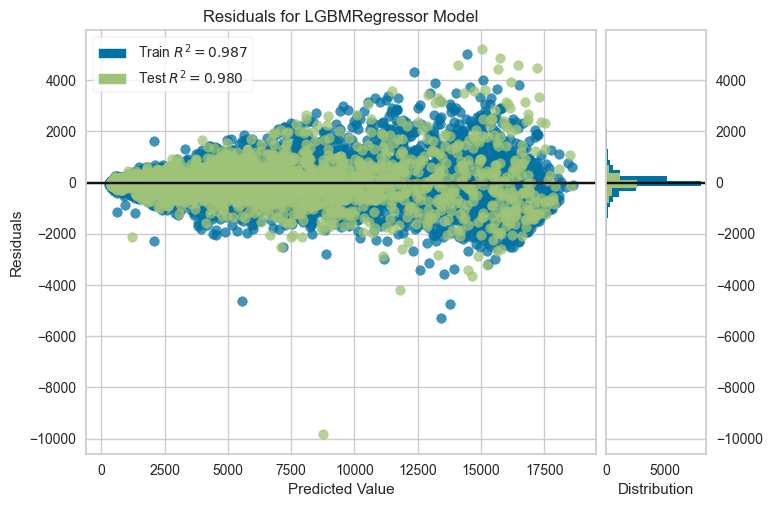

<AxesSubplot: title={'center': 'Residuals for LGBMRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [55]:
# Instantiate the linear model and visualizer
lgbm_cubic = (lgb.LGBMRegressor(random_state=42))
lgbm_cubic
visualizer = ResidualsPlot(lgbm_cubic)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure